# QIIME2-MICOM install + community tutorial 

### Find the ```q2-micom``` tutorial [here](https://micom-dev.github.io/q2-micom/)

### How to prepare your ```q2-micom``` environment
  - From Laurie: I created a venv using the .yml files for the qiime distribution and ```q2-micom``` addition
  - Find appropriate qiime distribution .yml for your purposes [here](https://docs.qiime2.org/2024.5/install/native/)
    - The ```q2-micom.yml``` should work with all QIIME2 versions 2021.2 or higher
    - I used ```qiime2-amplicon-2024.5.yml``` for macOS (Apple Silicon)
  - [```q2-micom.yml```](https://raw.githubusercontent.com/micom-dev/q2-micom/main/q2-micom.yml)

In [ ]:
#created a new qiime environment with a different name than my base qiime env
#just wanted to make sure this doesn't mess up my current install
micromamba env -n qiime2-amplicon-micom -f qiime2-amplicon-2024.5-py39-osx-conda.yml  

#activate this environment
micromamba activate qiime2-amplicon-micom 

#micromamba doesn't have an update command to update from .yml file
#use micromamba install instead
#if using conda or mamba, should be able to use update
#e.g. conda update -n qiime2-amplicon-micom -f q2-micom.yml
micromamba install -f q2-micom.yml

The tutorial uses a colorectal cancer dataset to practice ```q2-micom``` analysis workflows

## Building community models 

  - This tutorial uses the [AGORA 1.03 genus model database](https://zenodo.org/records/7739096/files/agora103_refseq216_genus_1.qza?download=1)    
  - MICOM model databases can be found [here](https://zenodo.org/records/7739096)
  - They also provide prebuilt [abundance table](https://github.com/micom-dev/q2-micom/raw/main/docs/cdi_table.qza) and [taxonomy](https://github.com/micom-dev/q2-micom/raw/main/docs/cdi_taxa.qza) files 
  <br>
  <br>
  - *Open question: what is the best way for us to create these files on our own?*
  <br>
  <br>
  - For growth simulations, we also need a medium for individual metabolites
    - This tutorial usees the AGORA database so they chose an AGORA medium
    - Download the [western_diet_gut_agora.qza](https://github.com/micom-dev/media/raw/main/media/western_diet_gut_agora.qza)
    - Other pre-made diet estimates can be found in the [MICOM media repository](https://github.com/micom-dev/media)
  <br>
  <br>
  - I organized my directory as shown below:
    ```bash 
      .
      ├── data
      │   ├── cdi_table.qza
      │   └── cdi_taxa.qza
      ├── diets
      │   └── western_diet_gut_agora.qza
      ├── env
      │   ├── q2-micom.yml
      │   └── qiime2-amplicon-2024.5-py39-osx-conda.yml
      ├── models
      │   └── agora103_refseq216_genus_1.qza
      ├── models.qza
      └── qiime2-micom-tutorial.ipynb
    ```
  - Building the community models takes a while, but usually needs to be done only once/sample
    - Many growth simulations can be run for a given sample using the model made here
    - In this tutorial, a warning should show that one sample doesn't match well to the database 
    - Choosing a larger database (or building based on a higher taxonomic rank) can help overcome this issue

In [3]:
# build community model
# input abundance table, taxonomy, and metabolic model database
# set parameters for cutoff (0.01% by default) and threads
# choose name for output model as qiime2 artifact file (.qza)
# --verbose will show a progress bar
!qiime micom build --i-abundance ./data/cdi_table.qza \
                  --i-taxonomy ./data/cdi_taxa.qza \
                  --i-models ./models/agora103_refseq216_genus_1.qza \
                  --p-cutoff 0.0001 \
                  --p-threads 4 \
                  --o-community-models ./models/models.qza \
                  --verbose

Merging with the database using ranks: genus
Running ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% 0:00:37[10/03/24 14:57:28] WARNING  Less than 50% of the abundance     ]8;id=300650;file:///Users/laurielyon/micromamba/envs/qiime2-amplicon-micom/lib/python3.9/site-packages/micom/community.py\community.py]8;;\:]8;id=728648;file:///Users/laurielyon/micromamba/envs/qiime2-amplicon-micom/lib/python3.9/site-packages/micom/community.py#229\229]8;;\
                             could be matched to the model                      
                             database. Model `ERR1883294` may                   
                             not be representative of the                       
                             sample                                             
Running ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 0:03:58m 0:00:14
Each community model contains 10-42 taxa (average 26+-11).
Community models cover 49.46%-99.91% of the total abundance (average 88.00%+-17.00%).
Saved

## Running a growth simulation 
#### Importing a growth media
  - Growth mediums provided in terms of fluxes
  - see section above for western diet (and other diets) to use in this step
  - make sure metabolite names match in databases (importance of using AGORA diet for AGORA database model)
  <br>
  <br>
#### Choosing a tradeoff parameter
  - tradeoff refers to the tradeoff between max community growth and individual taxon growth
  - ranges from 0 (no growth enforced) and 1 (enforce max community growth)
  - this value varies based on your study, so you can run a validation step first 

In [9]:
#validation step for tradeoff value
#input model.qza generated in last step and diet 
#will run growth simulation with many tradeoff values and track key metrics 
#this step took 2.0 hours to run on 8 cores
!qiime micom tradeoff --i-models ./models/models.qza \
                     --i-medium ./diets/western_diet_gut_agora.qza \
                     --p-threads 8 \
                     --o-results tradeoff.qza \
                     --verbose

Running ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 0:45:24m -:--:--
Saved TradeoffResults to: tradeoff.qza


In [10]:
#create visualization and view .qzv using https://view.qiime2.org
#output visualization shows histogram of growth rates on left
#fraction of growing taxa and mean line on right 
#lowering tradeoff gives more taxa that grow
!qiime micom plot-tradeoff --i-results tradeoff.qza \
                          --o-visualization tradeoff.qzv

Saved Visualization to: tradeoff.qzv


### Choosing a tradeoff parameter cont. 
  - my visualization didn't look exactly like the visualization shown in the tutorial
  - unsure why all taxa are growing until 0.7 
  <br>
  <br>
  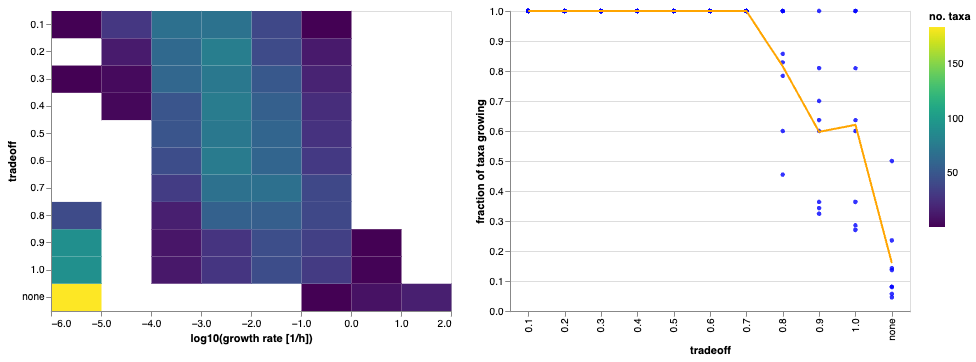
  <br>
  <br>
### Below, I parform the ```qiime micom grow``` command twice:
    - once with the 0.5 value shown in the tutorial
    - once with 0.8 where different growth rates appear for each sample 

In [13]:

#micom grow uses the same inputs as micom tradeoff above
#added parameter for tradeoff value
#output is a growth simulation .qza file
#this step took 6.75 minutes on 8 cores
!qiime micom grow --i-models ./models/models.qza \
                 --i-medium ./diets/western_diet_gut_agora.qza \
                 --p-tradeoff 0.5 \
                 --p-threads 8 \
                 --o-results growth_0_5.qza \
                 --verbose

Running ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 0:06:15m 0:00:12
Saved MicomResults to: growth_0_5.qza


In [14]:
#repeated with tradeoff value of 0.8
#took 6.5 minutes on 8 cores
!qiime micom grow --i-models ./models/models.qza \
                 --i-medium ./diets/western_diet_gut_agora.qza \
                 --p-tradeoff 0.8 \
                 --p-threads 8 \
                 --o-results growth_0_8.qza \
                 --verbose

Running ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 0:06:14m 0:00:14
Saved MicomResults to: growth_0_8.qza


### Visualizing growth rates
```qiime micom plot-growth``` can be used ot visualize growth rates
- each point in the .qzv shows one taxon/sample
- predicted growth rates shown for only those where growth is observed
- click a point to see taxa growth rates for only that sample 


In [15]:
#input growth simulation .qza
#output growth rates .qzv
!qiime micom plot-growth --i-results growth_0_5.qza \
                        --o-visualization growth_rates_0_5.qzv

!qiime micom plot-growth --i-results growth_0_8.qza \
                        --o-visualization growth_rates_0_8.qzv

Saved Visualization to: growth_rates_0_5.qzv
Saved Visualization to: growth_rates_0_8.qzv


### My ```plot-growth``` outputs
Here I'm just showing the top and bottom portions of the .qzv output
For these samples, ~70 genuses are represented in each visualization 

#### Tradeoff value of 0.5
  - x-axis values appear to span a wider range than tradeoff value below
  - taxa appear to be ordered from highest to lowest mean growth rate across included samples
<br>
<br>
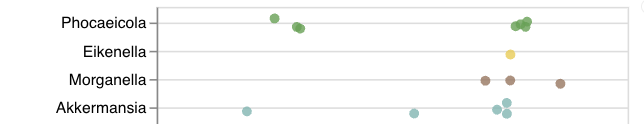
<br>
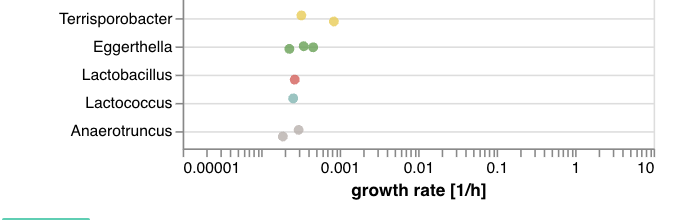

#### Tradeoff value of 0.8
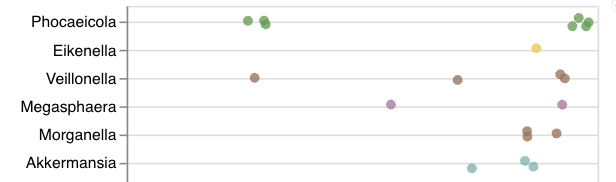
<br>
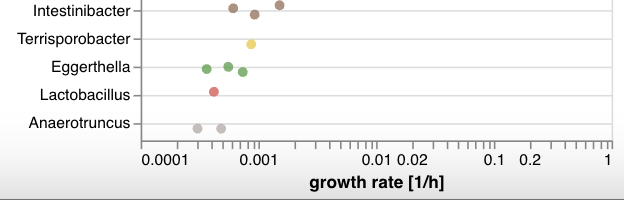


### ```qiime micom exchanges-per-sample``` to visualize metabolite consumption
  - net utilization or production of metabolites within the full community are shown
  - fluxes shown on log10 scale 
  - can look at production of metabolites with optional ```--p-direction export``` parameter


In [16]:
!qiime micom exchanges-per-sample --i-results growth_0_5.qza \
                                 --o-visualization exchanges_0_5.qzv

!qiime micom exchanges-per-sample --i-results growth_0_8.qza \
                                 --o-visualization exchanges_0_8.qzv

Saved Visualization to: exchanges_0_5.qzv
Saved Visualization to: exchanges_0_8.qzv


#### my exchange results
  - flux values varied significantly between my two tradeoff values 
  - both visualizations have ~100 metabolites represented
<br>
<br>
  - Growth tradeoff 0.5
    - 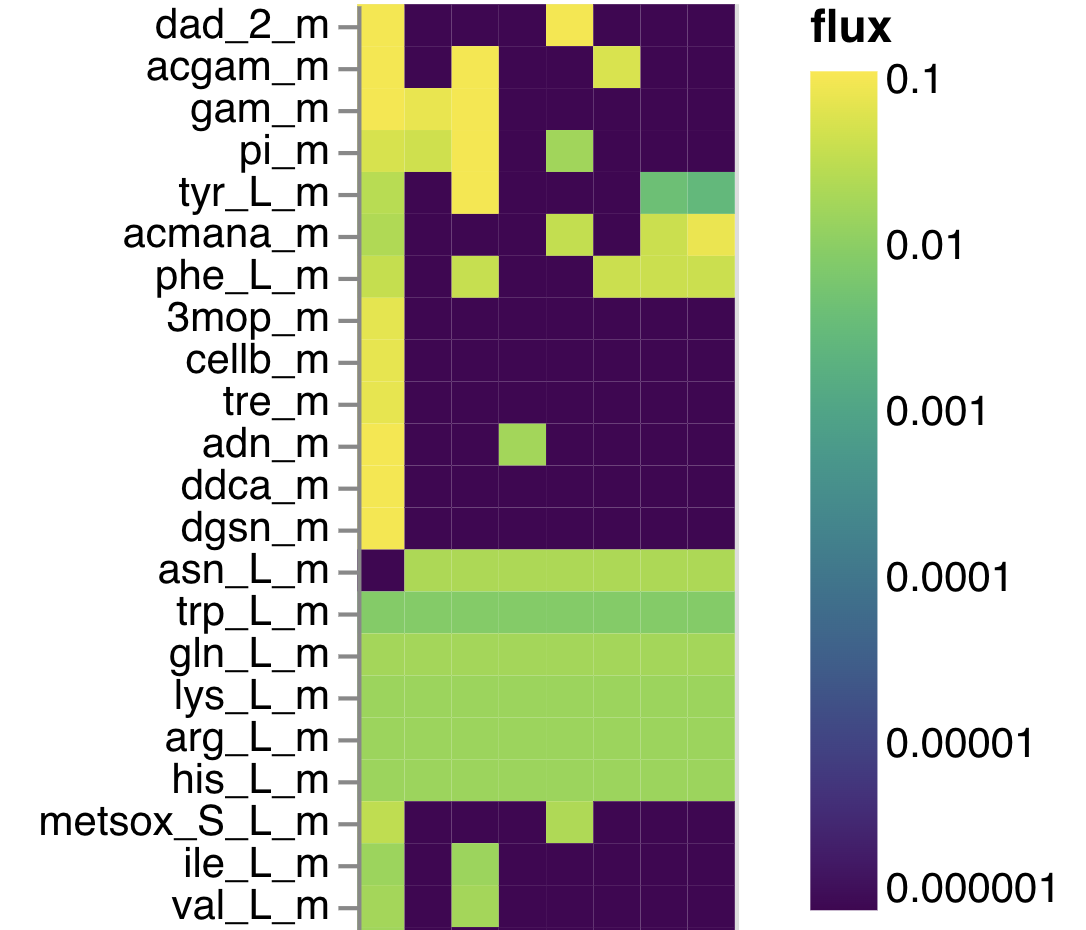
<br>
<br>
  - Growth tradeoff 0.8
    - 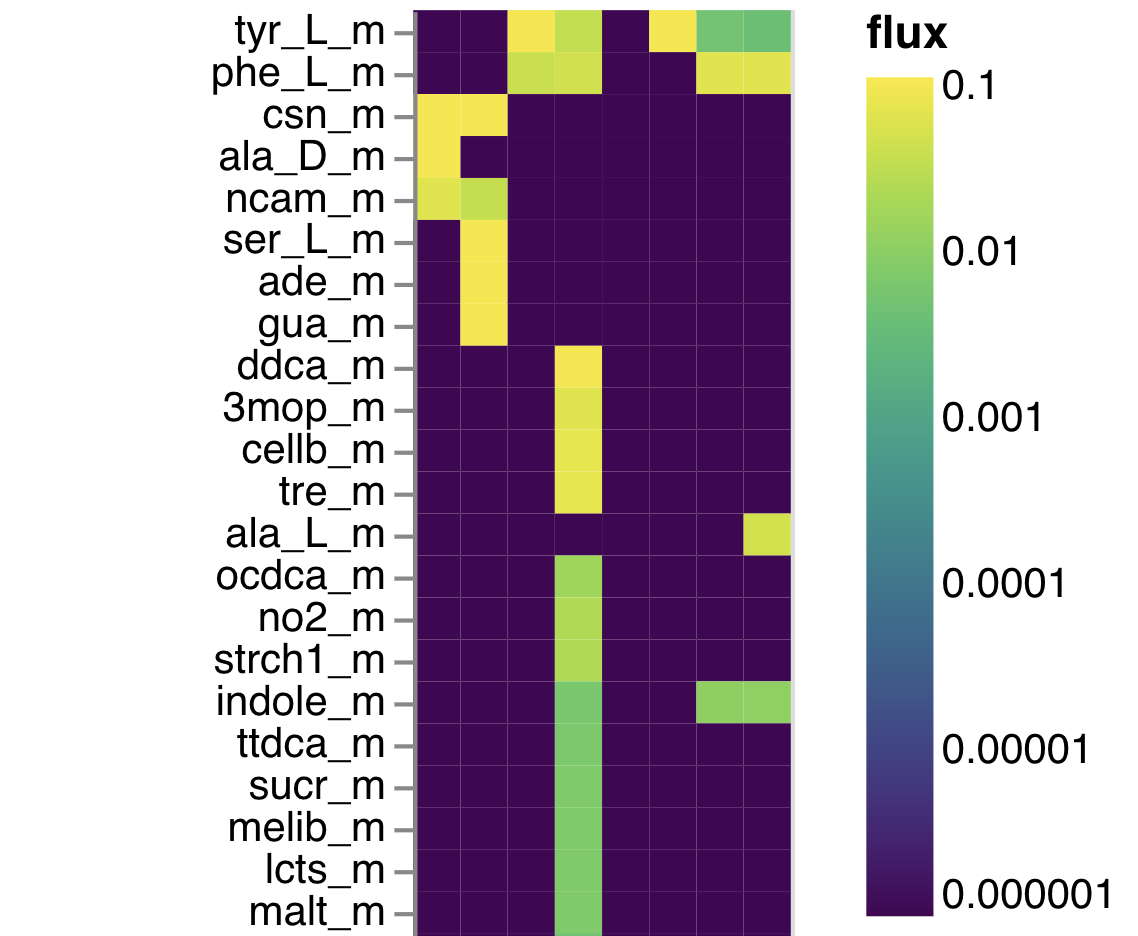
    

### ```qiime micom exchanges-per-taxon``` to visualize growth niches
  - consumption preferences for individual taxa 
  - data complexity needs to be lowered (impossible to visualize imports for each metabolite/taxon/sample)
    - reduce dimensions on metabolite axis with UMAP
    - represent metabolite imports as single point in 2D space
  <br>
  <br>
  
  - each taxon can then be plotted in each specific sample
    - taxa close together have similar growth niches
    - taxa far away from each other have more dissimilar growth requirements
  <br>
  <br>
 
  - input a ```growth.qza``` (from ```qiime micom grow``` function)
  - outputs a ```niche.qzv``` visualization
  <br>
  <br>
  
  - Note: can tune the UMAP reduction by using the parameters ```--p-n-neighbors``` and ```--p-min-dist```
  - Can look at metabolite production with ```--p-direction export``` tao observe weaker clustering, suggesting that there is considerably more overlap across taxa in metabolite production.


In [17]:
!qiime micom exchanges-per-taxon --i-results growth_0_5.qza \
                                --o-visualization niche_0_5.qzv

Saved Visualization to: niche_0_5.qzv


In [18]:
!qiime micom exchanges-per-taxon --i-results growth_0_8.qza \
                                --o-visualization niche_0_8.qzv

Saved Visualization to: niche_0_8.qzv


#### My growth niche results
  - generally shows similar clustering trends, but not in all cases
  - looked at Akkermansia, Bacteroides, and Phocaeicola (Bacteroides circled in below examples)
  - are TSNE1 and TSNE2 flipped between my graphs? different taxa tradeoff could account for trend differences

- tradeoff 0.5 niche visualization (Bacteroides samples circled manually for visualization of differences)
  - ![Screenshot 2024-10-07 at 11.07.42 AM.png](<attachment:Screenshot 2024-10-07 at 11.07.42 AM.png>)

- tradeoff 0.8 niche visualization (Bacteroides samples circled manually for visualization of differences)
  - ![Screenshot 2024-10-07 at 11.11.38 AM.png](<attachment:Screenshot 2024-10-07 at 11.11.38 AM.png>)
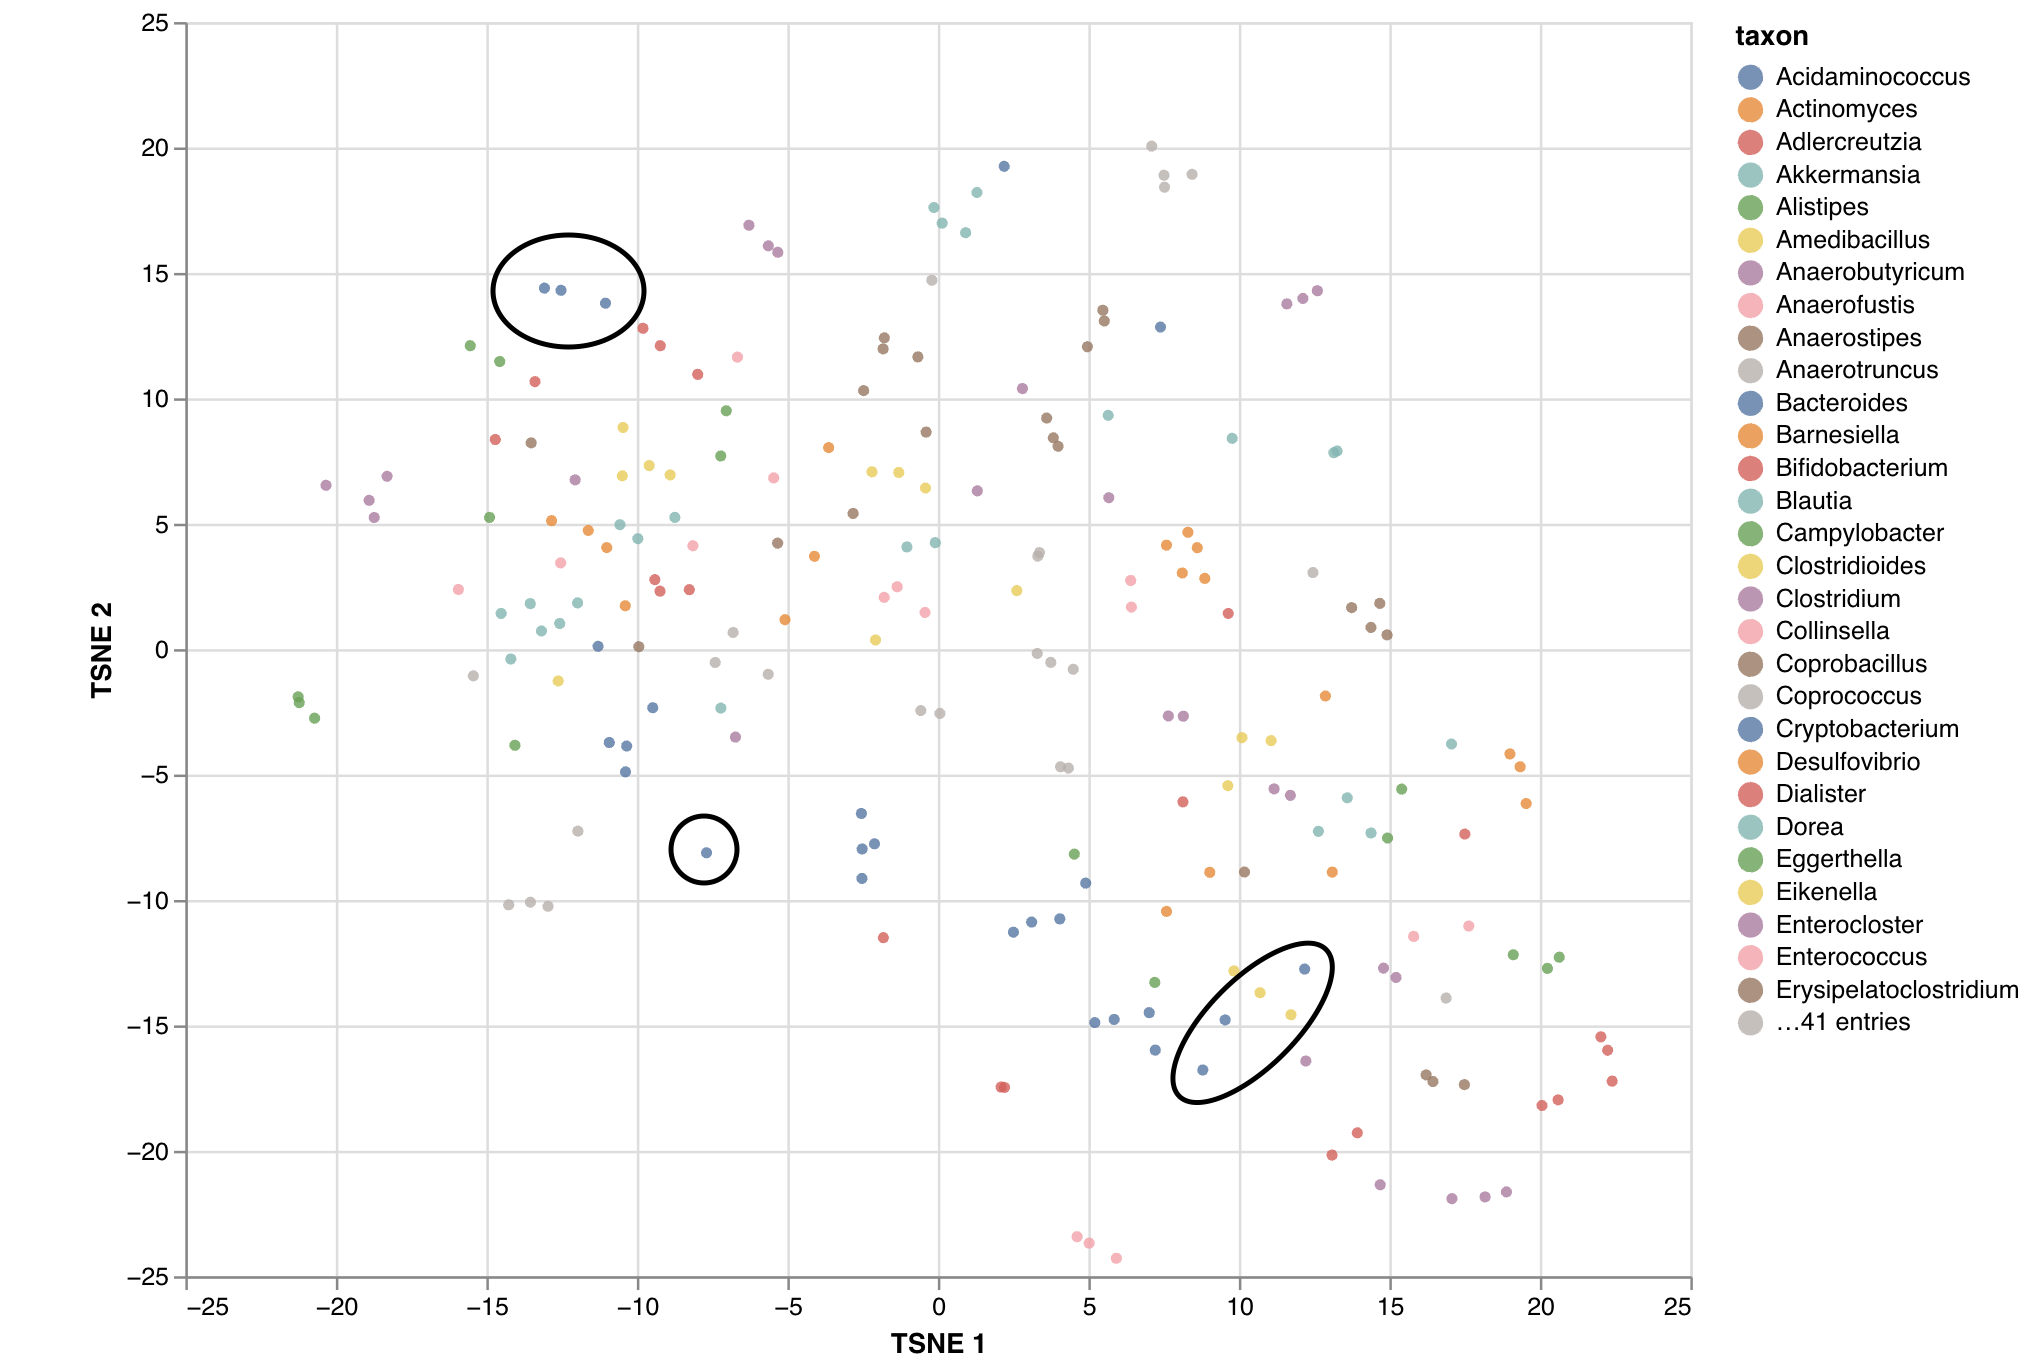
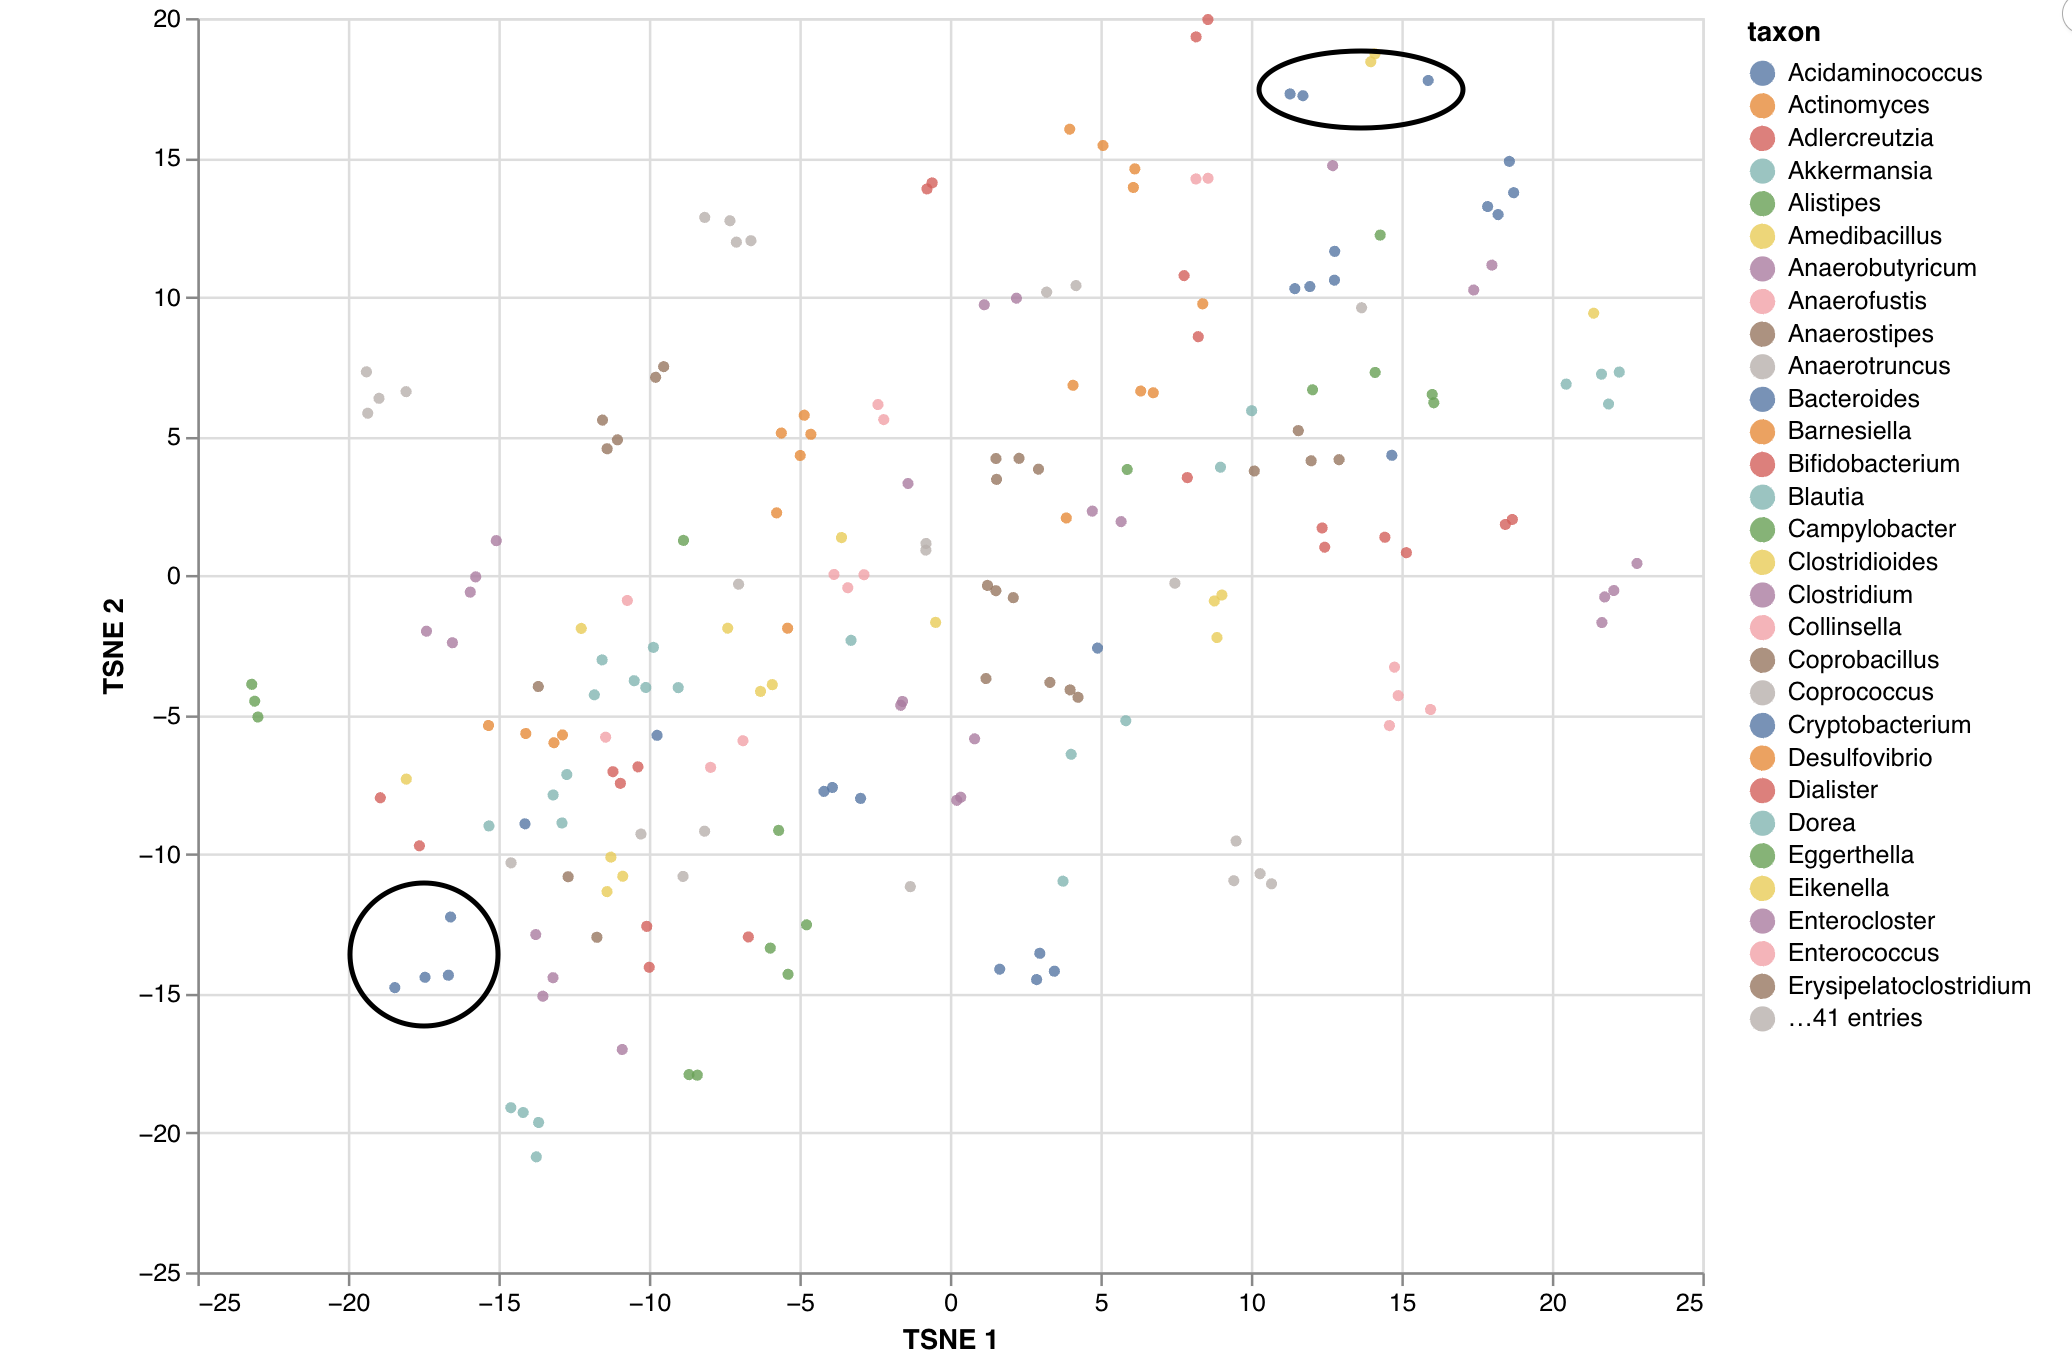

### ```qiime micom association``` to associate fluxes with host phenotype
  - requires a Qiime2 [metadata.tsv](https://raw.githubusercontent.com/Gibbons-Lab/isb_course_2023/main/data/metadata.tsv)
    - specifies phenotype of interest 
    - in tutorial, a healthy or cancer status is assigned to each sample in the column ```"disease_state"```
    - ```q2-micom``` supports binary or continuous phenotype data 
      - in this tutorial, a binary phenotype is given as "healthy" or "Pre-FMT"
      - to define a continuous phenotype ```--p-variable-type continuous```
  - overall fluxes are used as a default by ```q2 micom```, 
    but can also look for differences in import fluxes only with ```--p-flux-type import```

In [19]:
#association for growth with tradeoff of 0.5
!qiime micom association --i-results growth_0_5.qza \
                        --p-fdr-threshold 0.3 \
                        --m-metadata-file metadata.tsv \
                        --m-metadata-column disease_state \
                        --o-visualization associations_0_5.qzv

Saved Visualization to: associations_0_5.qzv


In [20]:
#association for growth with tradeoff of 0.8
!qiime micom association --i-results growth_0_8.qza \
                        --p-fdr-threshold 0.3 \
                        --m-metadata-file metadata.tsv \
                        --m-metadata-column disease_state \
                        --o-visualization associations_0_8.qzv

Saved Visualization to: associations_0_8.qzv


#### Results of association visualizations
  - positive logFC indicates a significantly higher flux of that metabolite in healthy subject than pre-FMT
  - 0.8 showed no significant negative fold changes (higher flux in pre-FMT), whereas 0.5 did
  - each show different order and some differences in significant metabolites 
  - both models show "training accuracy = 1.0" for the model performance
    - 0.8 has less variation in cross-validation accuracy -- what are the implications of this?
  <br>
  <br>
  - Default parameter for flux/metabolite/sample (bottom left graph) is null (shows all dots)
    - I set to 4hbz[e] to highlight difference between my two tradeoff models 
  <br>
  <br>
  - associations for 0.5 tradeoff
  <br>
  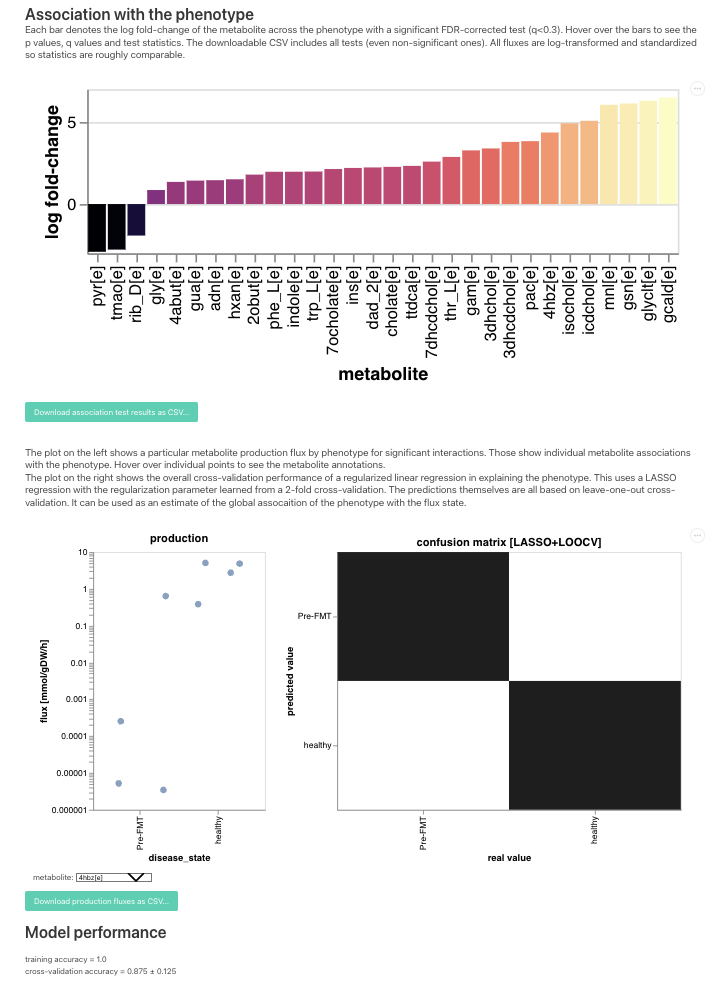
  <br>
  <br>
  - associations for 0.8 tradeoff
  <br>
  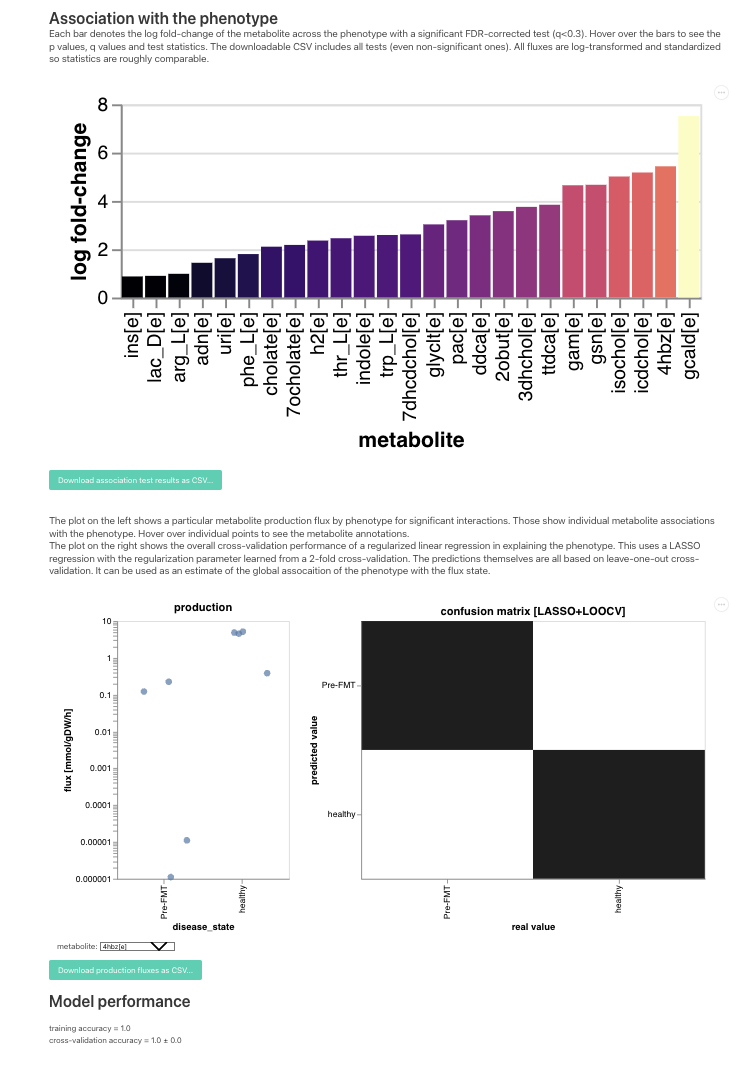

## Further data exploration 
### Filtering already built community models or simulation results
   - ```qiime micom filter-models``` and ```qiime micom filter-results```
   - Requirements:
     - inputting a model.qza with ```--i-models```
     - providing a metadata.tsv file with ```--m-metadata```
      - includes only samples of interest OR use pandas query to select only samples of interest
      - pandas query example used in tutorial: ```--p-query "disease_state == 'healthy'"```
      - the parameter ```---p-exclude``` can also be used to *exclude* all samples provided by the metadata or query
     - specify an output file (.qza) with either ```--o-filtered-models``` or ```--o-filtered-results```

### Identify metabolites 
  - the metabolite IDs returned by MICOM can be confusing 
  - use ```qiime tools export``` to export detailed annotations from growth results
  - example: ```qiime tools export --input-path growth.qza --output-path growth``
    - this would create a filed called ```annotations.csv``` within the ```growth``` folder 


In [22]:
!qiime tools export --input-path growth_0_8.qza --output-path growth

Exported growth_0_8.qza as MicomResultsDirectory to directory growth


### Getting growth and flux data for additional analyses 
The ```q2-micom``` module returns data as a pandas DataFrame
See below example for 

In [ ]:
from q2_micom import read_results

res = read_results("growth_0_8.qza")

In [ ]:
##example of visualization 
res.exchange_fluxes.head()

Output from ```exchange_fluxes.head()```
<br>
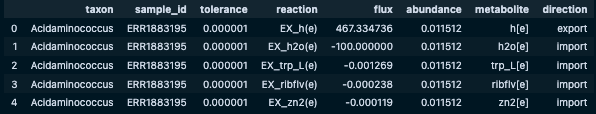

In [ ]:
##example of visualization 
res.growth_rates.head()

Output from ```growth_rates.head()```
<br>
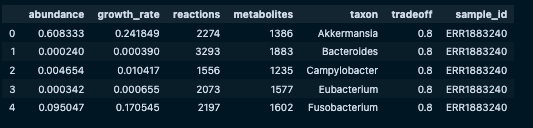